# Classification from images

In this example we build a clasification model to recognise differnet kinds of images. This example uses limited data and is inspired by the keras blog post "Building powerful image classification models using very little data" from https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html. 

The datasets used are from kaggle 
* cats and dogs https://www.kaggle.com/c/dogs-vs-cats
* monkeys https://www.kaggle.com/slothkong/10-monkey-species/home 
* flowers https://www.kaggle.com/alxmamaev/flowers-recognition


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle

from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
import PIL

Using TensorFlow backend.


## Data

Set up the data set process. We provide the name of a folder contianing images. There are two assumptions:
* The images of differnet classes are contained in folders with class ids
* A csv file called class_labels exists which is a map from class ids to class names (for printing)

In [3]:
# dataset name
#dataset_name = 10-monkey-species
dataset_name = 'flowers'
#dataset_name = 'cats_and_dogs'

# assuming data is contained in a train and a validation set
train_data_dir = dataset_name + '/train/'

# Set up some parmaeters for data loading
sample_rate = 1.0

# desired dimensions of our images.
img_width, img_height = 150, 150

# different backends (e.g. tensorflow and theano) use different orderings for image data - fix this!
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Load image data.

In [4]:
training_class_folders = [i for i in os.listdir(train_data_dir) if not i.startswith('.')] # use this for full dataset
num_classes = len(training_class_folders)

# Initialise arrays for data storage
X_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.str)
    
# Loop through the class folders
for i, image_cls in enumerate(training_class_folders):
    
    print('Processing class {}'.format(image_cls))
    image_class_folder = train_data_dir + image_cls + "/"

    # generate filenames from the data folder and do sampling
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for image data
    count = len(image_filenames)
    X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

    # Iterate throuigh the filenames and for each one load the image, resize and normalise
    for i, image_file in enumerate(image_filenames):

        # Low the images and resize them
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image = image[:,:,[2,1,0]] # OpenCV and matplotlib use differnet channel oerderings so fix this
        
        # If channel order of network does not match open cv format swap it
        if K.image_data_format() == 'channels_first':
            image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
            
        # Add image data to data array and normalise
        X_data_part[i] = image
        X_data_part[i] = X_data_part[i]/255
        
        # Add label to label array
        y_data = np.append(y_data, image_cls)
        
        if i%100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array
    X_data = np.append(X_data, X_data_part, axis=0)
    
print("Data shape: {}".format(X_data.shape))

Processing class daisy
Processed 0 of 769 for class daisy 
Processed 100 of 769 for class daisy 
Processed 200 of 769 for class daisy 
Processed 300 of 769 for class daisy 
Processed 400 of 769 for class daisy 
Processed 500 of 769 for class daisy 
Processed 600 of 769 for class daisy 
Processed 700 of 769 for class daisy 
Processed 769 of 769 for class daisy 
Processing class dandelion
Processed 0 of 1052 for class dandelion 
Processed 100 of 1052 for class dandelion 
Processed 200 of 1052 for class dandelion 
Processed 300 of 1052 for class dandelion 
Processed 400 of 1052 for class dandelion 
Processed 500 of 1052 for class dandelion 
Processed 600 of 1052 for class dandelion 
Processed 700 of 1052 for class dandelion 
Processed 800 of 1052 for class dandelion 
Processed 900 of 1052 for class dandelion 
Processed 1000 of 1052 for class dandelion 
Processed 1052 of 1052 for class dandelion 
Processing class rose
Processed 0 of 784 for class rose 
Processed 100 of 784 for class rose 


Split data into training and test partitions

In [5]:
# Perfrom split to train, validation, test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

Reshape output data for use with a neural network.

In [9]:
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

Record the number to label mapping 

In [10]:
classes_num_label = dict()

for idx, lbl in enumerate(y_train_encoder.classes_):
    classes_num_label[idx] = lbl

Print a few randomly sampled example images.

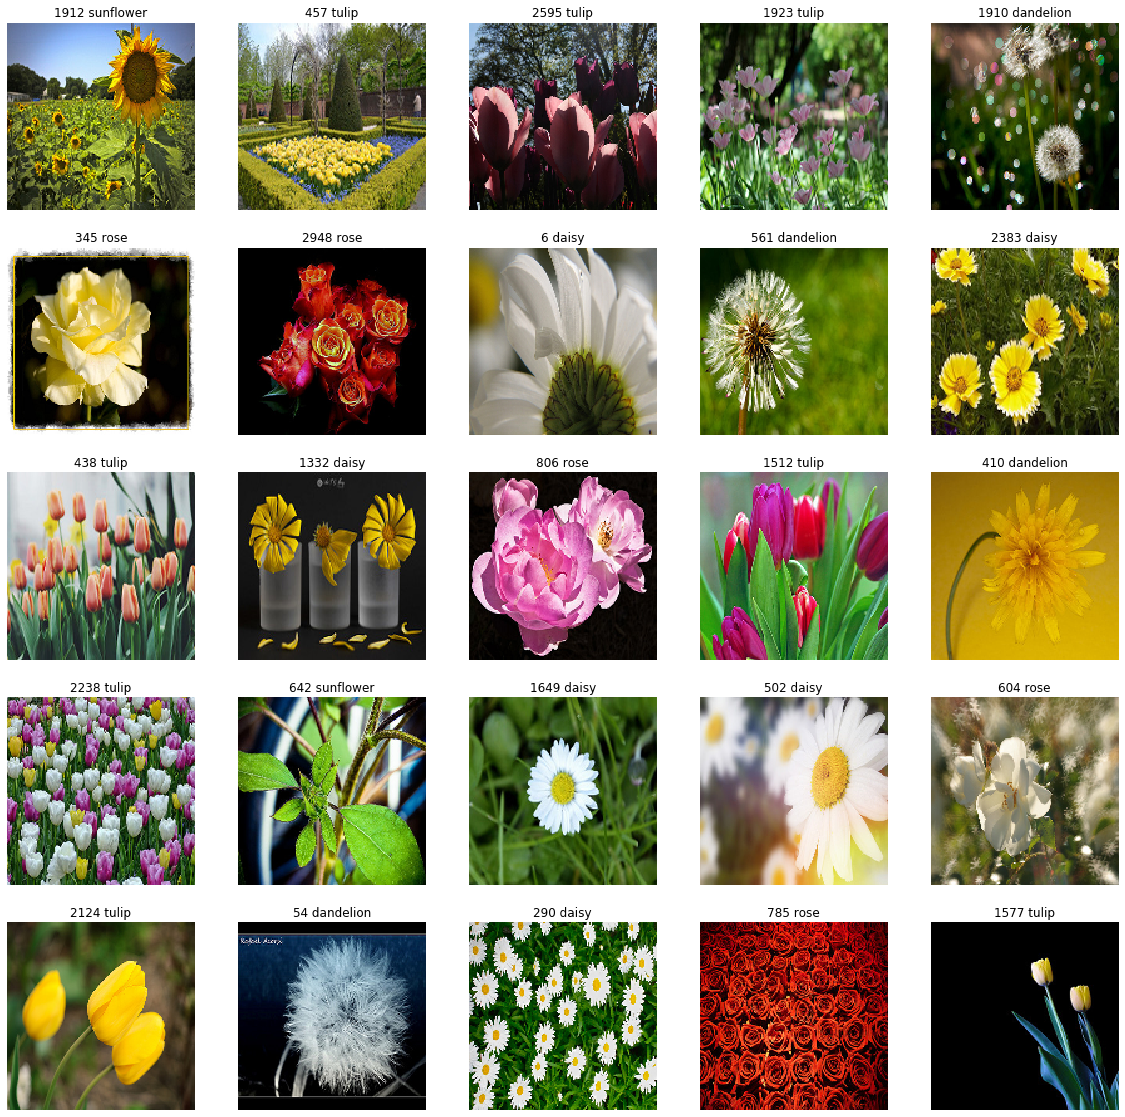

In [11]:
pltsize=4
row_images = 5
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))
from PIL import Image
for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    im = PIL.Image.fromarray((X_train[i_rand] * 255).astype(np.uint8))
    plt.imshow(im)
    plt.title((str(i_rand) + " " + y_train[i_rand]))
    # print('Training sample',i_rand,': class:',y_train[i_rand])

## Modelling

Create model architecture

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)       

Train the model. We allow the model to overfit but save the best set of weights based on validation loss as we go. Then at the end of training (assuming the model has overfit) we revert back to the saved model.

In [13]:
batch_size = 128
epochs = 50

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_notebook21.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)

history = model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

#reload best weights
model.load_weights(best_weights_filepath)

Train on 2420 samples, validate on 606 samples
Epoch 1/50
2420/2420 [==============================] - 48s 20ms/step - loss: 0.5278 - accuracy: 0.7887 - val_loss: 0.4719 - val_accuracy: 0.8017
Epoch 2/50


C:\Program Files\Anaconda\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


2420/2420 [==============================] - 36s 15ms/step - loss: 0.4325 - accuracy: 0.8064 - val_loss: 0.4019 - val_accuracy: 0.8132
Epoch 3/50
2420/2420 [==============================] - 48s 20ms/step - loss: 0.3888 - accuracy: 0.8198 - val_loss: 0.3733 - val_accuracy: 0.8304
Epoch 4/50
2420/2420 [==============================] - 49s 20ms/step - loss: 0.3665 - accuracy: 0.8360 - val_loss: 0.3644 - val_accuracy: 0.8333
Epoch 5/50
2420/2420 [==============================] - 51s 21ms/step - loss: 0.3492 - accuracy: 0.8459 - val_loss: 0.3775 - val_accuracy: 0.8228
Epoch 6/50
2176/2420 [=========================>....] - ETA: 4s - loss: 0.3258 - accuracy: 0.8584

KeyboardInterrupt: 

Plot some evaluation stats

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [ ]:
# Make a set of predictions for the training data
pred = model.predict_classes(X_train)

# Print performance details
print(metrics.classification_report(y_train_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train_num, pred))

## Evaluation

In [ ]:
# Make a set of predictions for the test data
pred = model.predict_classes(X_test)

# Print performance details
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred))

Draw some examples of correct classifications 

In [ ]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(sp.misc.toimage(X_test[i]))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test[i]))
        ii = ii + 1

Draw some examples of mis-classifications 

In [ ]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
errors = predictions != y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if errors[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(sp.misc.toimage(X_test[i]))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test[i]))
        ii = ii + 1